The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Nada Adel\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


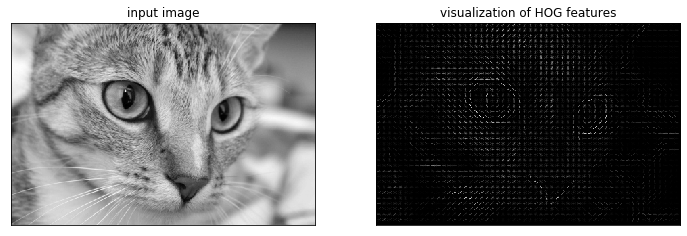

In [89]:
import numpy as np
# import skimage.io as io
import cv2
from skimage.measure import find_contours
from skimage.draw import rectangle
import os
# import utils as utils
from enum import Enum
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from skimage import data, color, feature
import skimage.data
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualise=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [90]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches=positive_patches[:1000,:,:]
positive_patches.shape

(1000, 62, 47)

In [91]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [92]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

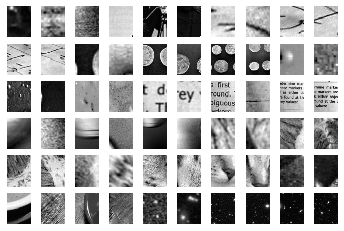

In [93]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [94]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [95]:
X_train.shape

(31000, 1215)

In [96]:
from sklearn.naive_bayes import GaussianNB
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score,GridSearchCV
cross_val_score(GaussianNB(), X_train, y_train)

C:\Users\Nada Adel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.96700213, 0.99506436, 0.99351592])

In [97]:
from sklearn.svm import LinearSVC
# from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

C:\Users\Nada Adel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Nada Adel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Nada Adel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Nada Adel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Nada Adel\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converg

0.9970322580645161

In [98]:
grid.best_params_

{'C': 1.0}

In [99]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

C:\Users\Nada Adel\Anaconda3\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


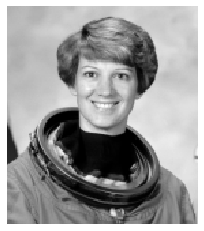

In [100]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [101]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [102]:
labels = model.predict(patches_hog)
labels.sum()

23.0

In [103]:


import numpy as np
 
#  Felzenszwalb et al.
def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 # initialize the list of picked indexes
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(x2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]
 
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
 
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
 
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
 
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
    # return only the bounding boxes that were picked
    return boxes[pick]

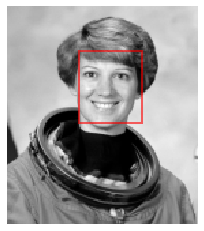

In [104]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
lab=np.copy(labels)
indices=indices[lab==1]
sent=np.zeros((indices.shape[0],4))
sent[:,0]=indices[:,0]
sent[:,1]=indices[:,1]
sent[:,2]=indices[:,0]+Ni
sent[:,3]=indices[:,1]+Nj
boxes= non_max_suppression_slow(sent,0.01)
for i, j,k,l in boxes :
     ax.add_patch(plt.Rectangle((j, i), Nj, Ni-9, edgecolor='red',
                                alpha=0.6, lw=2, facecolor='none'))


In [105]:
def get_position(input_image):
#     input_image=skimage.color.rgb2gray(input_image)
    tmp1=np.copy(input_image)
#     show_images([tmp1])
    input_image=  rgb2gray(input_image)
    input_image = skimage.transform.rescale(input_image, 0.25)
    input_image = input_image[:, :]

    indices, patches = zip(*sliding_window(input_image))
    patches_hog = np.array([feature.hog(patch) for patch in patches])
    patches_hog.shape
    labels = model.predict(patches_hog)
#     labels.sum()
    fig, ax = plt.subplots()
    ax.imshow(input_image, cmap='gray')
    ax.axis('off')

    Ni, Nj = positive_patches[0].shape
    indices = np.array(indices)
    lab=np.copy(labels)
    indices=indices[lab==1]
    sent=np.zeros((indices.shape[0],4))
    sent[:,0]=indices[:,0]
    sent[:,1]=indices[:,1]
    sent[:,2]=indices[:,0]+Ni
    sent[:,3]=indices[:,1]+Nj
    boxes= non_max_suppression_slow(sent,0.01)
    for i, j,k,l in boxes :
         ax.add_patch(plt.Rectangle((j, i), Nj, Ni-9, edgecolor='red',
                                    alpha=0.6, lw=2, facecolor='none'))
    tmp1 = tmp1[int(boxes[0][0]*(4)):int(boxes[0][2]*(4)), int(boxes[0][1]*(4)):int(boxes[0][3]*(4))]
    return tmp1 

In [106]:
import numpy as np
import skimage.io as io
from skimage.color import rgb2gray,gray2rgb
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_mean,threshold_triangle,try_all_threshold
from sklearn import cluster
from sklearn.cluster import DBSCAN
from scipy import ndimage
import collections
from collections import Counter
import math 
from skimage.feature import greycomatrix, greycoprops
from  more_itertools import unique_everseen
import cv2 , dlib

from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
def edge_detector(simage,flag):
    alpha = 1.2
    P =[-3,-2,-1,0,1,2,3]
    Q =[-3,-2,-1,0,1,2,3]
    k = [2,3,4,5,6,10,11,12,13,14]
    size_of_kernal=7
    list_kernals=[]
    arr_orient = []
    for i in range(10):
        kernal=np.zeros((7,7))
        angle = np.dot(k[i],(22.5))
        arr_orient.append(angle)
        angle = angle*(math.pi/180)
        sumk=0
        for p in range(size_of_kernal):
            for q in range(size_of_kernal):  
                sumGNeg=(1/(2*np.pi*pow(alpha,2))) * np.exp(- (pow(P[p] - (alpha*np.cos(angle)),2) + pow(Q[q]- (alpha*np.sin(angle)),2))/(2*pow(alpha,2)))
                sumGPos=(1/(2*np.pi*pow(alpha,2))) * np.exp(- (pow(P[p] + (alpha*np.cos(angle)),2) + pow(Q[q]+ (alpha*np.sin(angle)),2))/(2*pow(alpha,2)))
                kernal[p,q]=sumGNeg-sumGPos
                if kernal[p,q]>0:
                    sumk+=kernal[p,q]
        kernal = kernal / sumk                    
        list_kernals.append(kernal)

    arr =[]
    for i in range(10):
        CImg = convolve2d(simage,list_kernals[i])
        arr.append(CImg)

    out = np.zeros(simage.shape)
    Orient = np.zeros(simage.shape)
    listR = []
    for i in range(simage.shape[0]):
        for j in range(simage.shape[1]):
            for KE in range (10):
                listR.append(arr[KE][i,j])
            out[i,j] = np.amax(listR)
            Orient[i,j] = arr_orient[int(np.where(listR == out[i,j])[0])]
            listR.clear()

    thre = threshold_mean(out)
    #print(thre)
    if(flag == 0):
        out = out < 2*thre
    else:
        out = out < thre
    show_images([out])
    return out , Orient

def CountFrequency(arr): 
    return collections.Counter(arr) 

def check_availability(element, collection: iter):
    return element in collection

def image_with_land(image2, all_landmarks):
    #image2 = cv2.imread(image)
    all_landmarks
    arr = np.array(all_landmarks)
    arr = arr[::40]
    cv2.drawContours(image2, arr, -1, (255, 0, 0), 3)
    show_images([image2])
    #imS = cv2.resize(image2, (540, 540))  
    #cv2.imshow("Frame", imS)
    #cv2.waitKey(0) 
    #cv2.destroyAllWindows()

In [112]:
def landmarks_detection(image,flag):
    image_cv = np.copy(image)
    #image = io.imread(image)
    img = rgb2gray(image)
    blurred_f = ndimage.gaussian_filter(img, 3)
    filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
    alpha = 1000
    sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
    simage = sharpened
    
    out,Orient = edge_detector(simage,flag)
    
    arr_coord =[]
    for i in range(out.shape[0] ):
        for j in range(out.shape[1]):
            if out[i,j]==False:
                arr_coord.append([i,j])

    db = DBSCAN(eps = 3, min_samples=3).fit(arr_coord)  
    labels = db.labels_
    Exact_lab = []
    freq = CountFrequency(labels)
    for lab , fr in freq.items(): 
        if(fr > 150):
            Exact_lab.append(lab)

    out2 = np.ones(simage.shape)
    k = 0
    E_labels = []
    for i in range(out2.shape[0]):
        for j in range(out2.shape[1]):
            if out[i,j] == False:
                res = check_availability(labels[k], Exact_lab)
                if (res):
                    out2[i][j] = 0
                    E_labels.append(labels[k])
                k += 1
                
    show_images([out2])            
    freq = CountFrequency(E_labels)
    Horizontal_lab = []

    for lab , fr in freq.items():
        sumHorizontal = 0
        k = 0
        for i in range(out2.shape[0]):
            for j in range(out2.shape[1]):
                if out2[i][j] == False:   
                    if( E_labels[k] == lab ):
                        if(Orient[i][j] == 315.0 or Orient[i][j] == 45.0 ):
                            sumHorizontal += 1
                    k += 1
        if ( (sumHorizontal / fr )*100 >= 30):
            Horizontal_lab.append(lab)
    out3 = np.ones(simage.shape)
    k = 0
    for i in range(out3.shape[0]):
        for j in range(out3.shape[1]):
            if out2[i,j] == False:
                res = check_availability(E_labels[k], Horizontal_lab)
                if (res):
                    out3[i][j] = 0
                k += 1
                
                
    NI = int(0.1*out3.shape[0])

    arr3_coord =[]
    for i in range(2*NI , out3.shape[0] - NI):
        for j in range(out3.shape[1]):
            if out3[i,j]==False:
                arr3_coord.append([i,j])

    db3 = DBSCAN(eps=10, min_samples=3).fit(arr3_coord)


    K_list = db3.labels_
    land_clusters = []
    if( len(list(unique_everseen(K_list))) > 4):
        for l in range(4):
            test_list = Counter(K_list)
            res = test_list.most_common(1)[0][0] 
            land_clusters.append(res)
            K_list = K_list[K_list != res]
    else :
        land_clusters = list(unique_everseen(K_list))
    land_clusters.sort()

    RE = []
    LE = []
    N = []
    M = []
    all_landmarks = []
    out_ = np.zeros([simage.shape[0],simage.shape[1],3],dtype=np.uint8)
    k = 0
    for i in range(2*NI , out3.shape[0] - NI):
        for j in range(out3.shape[1]):
              if out3[i,j] == False:

                res = check_availability(db3.labels_[k], land_clusters)
                if (res):
                    all_landmarks.append([[j,i]])
                    if(land_clusters[0] == db3.labels_[k]):
                        out_[i][j] = [255,0,0]
                        RE.append([i,j])
                    elif(land_clusters[1] == db3.labels_[k]):
                        LE.append([i,j])
                        out_[i][j] = [0,255,0]

                    elif(land_clusters[2] == db3.labels_[k]):
                        N.append([i,j])
                        out_[i][j] = [0,0,255]

                    elif(land_clusters[3] == db3.labels_[k]):
                        M.append([i,j])
                        out_[i][j] = [255,255,0]


                k += 1   
    show_images([out_])
    image_with_land(image_cv , all_landmarks)

    RER = image[np.amin(RE, axis = 0)[0]: np.amax(RE, axis = 0)[0] , np.amin(RE, axis = 0)[1]: np.amax(RE, axis = 0)[1] ]
  
    REL =  image[np.amin(LE, axis = 0)[0]: np.amax(LE, axis = 0)[0] , np.amin(LE, axis = 0)[1]: np.amax(LE, axis = 0)[1] ] 

    if(N != []):
        N_ =  image[np.amin(N, axis = 0)[0]: np.amax(N, axis = 0)[0] , np.amin(N, axis = 0)[1]: np.amax(N, axis = 0)[1] ] 
    else:
        N_ = []

    if(M != []):
        M_ =  image[np.amin(M, axis = 0)[0]: np.amax(M, axis = 0)[0] , np.amin(M, axis = 0)[1]: np.amax(M, axis = 0)[1] ] 
    else:
        M_ =N_
        
    L = [RE ,LE ,N ,M]
    boxes = [RER , REL , N_ , M_ ]
    show_images([RER , REL , N_ , M_ ])
    return L , boxes

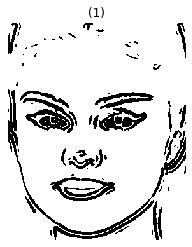

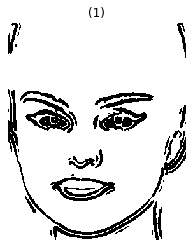

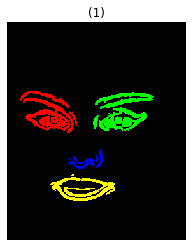

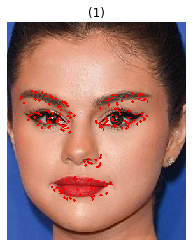

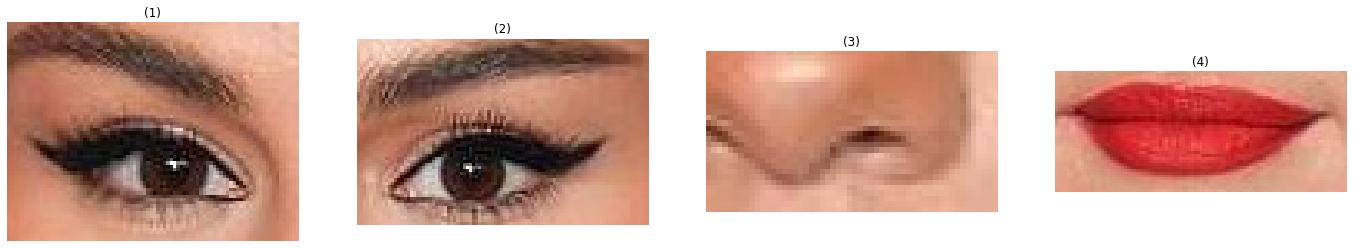

([[[108, 39],
   [108, 40],
   [108, 41],
   [108, 42],
   [108, 43],
   [108, 44],
   [109, 32],
   [109, 33],
   [109, 34],
   [109, 35],
   [109, 36],
   [109, 37],
   [109, 38],
   [109, 39],
   [109, 40],
   [109, 41],
   [109, 42],
   [109, 43],
   [109, 44],
   [109, 45],
   [109, 46],
   [109, 47],
   [109, 48],
   [109, 49],
   [110, 29],
   [110, 30],
   [110, 31],
   [110, 32],
   [110, 33],
   [110, 34],
   [110, 35],
   [110, 36],
   [110, 37],
   [110, 38],
   [110, 39],
   [110, 40],
   [110, 41],
   [110, 42],
   [110, 43],
   [110, 44],
   [110, 45],
   [110, 46],
   [110, 47],
   [110, 48],
   [110, 49],
   [110, 50],
   [110, 51],
   [110, 52],
   [110, 53],
   [111, 28],
   [111, 29],
   [111, 30],
   [111, 31],
   [111, 32],
   [111, 33],
   [111, 34],
   [111, 35],
   [111, 36],
   [111, 37],
   [111, 38],
   [111, 39],
   [111, 40],
   [111, 41],
   [111, 42],
   [111, 43],
   [111, 44],
   [111, 45],
   [111, 46],
   [111, 47],
   [111, 48],
   [111, 49],
   [11

In [113]:
##rec2=io.imread('www.jpg')
        #if( rec1 != []):
landmarks_detection(io.imread('www.jpg'), 0)

C:\Users\Nada Adel\Anaconda3\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


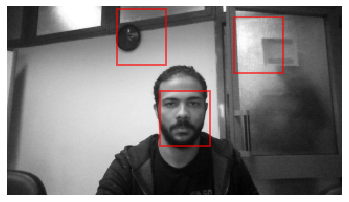

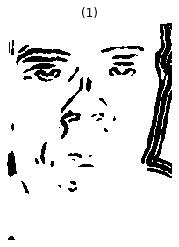

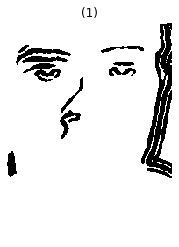

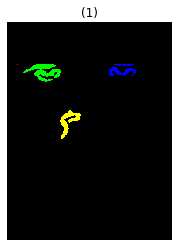

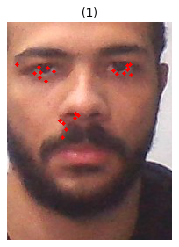

ValueError: zero-size array to reduction operation minimum which has no identity

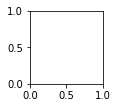

In [115]:
fff=io.imread("WIN_20191217_16_13_29_Pro.jpg")
face = get_position(fff) 
L2 , boxs2 = landmarks_detection(face,0)

show_images([face])

In [110]:
def face_swap(img1, img2, L1, L2,box1, box2):
    for i in range(4):
        tmp =  np.copy(box1[i])
        print(tmp.shape)
        tmp = cv2.resize(tmp, (box2[i].shape[1],  box2[i].shape[0]))
        img2[np.amin(L2[i], axis = 0)[0]: np.amax(L2[i], axis = 0)[0] , np.amin(L2[i], axis = 0)[1]: np.amax(L2[i], axis = 0)[1]] = tmp
        
    return img2   

C:\Users\Nada Adel\Anaconda3\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


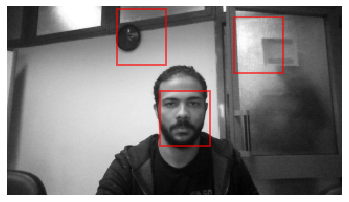

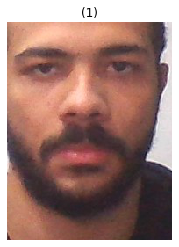

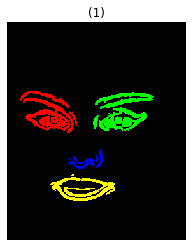

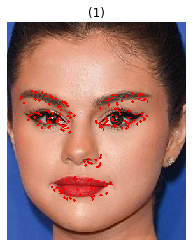

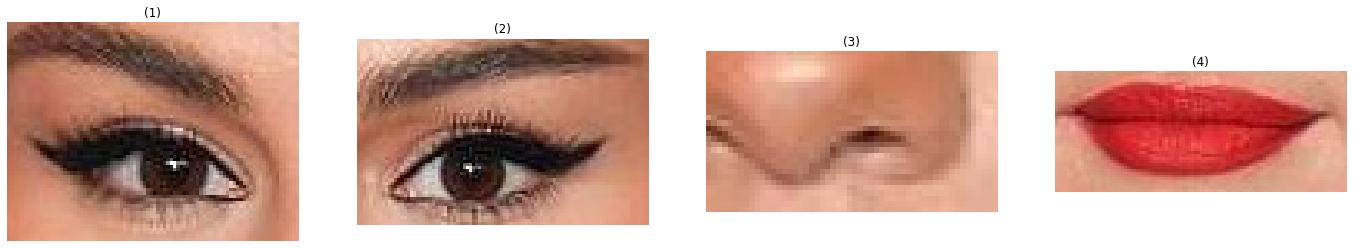

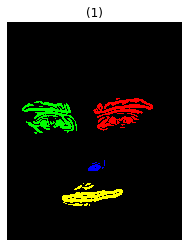

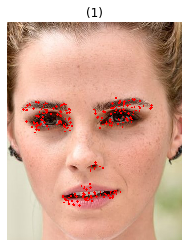

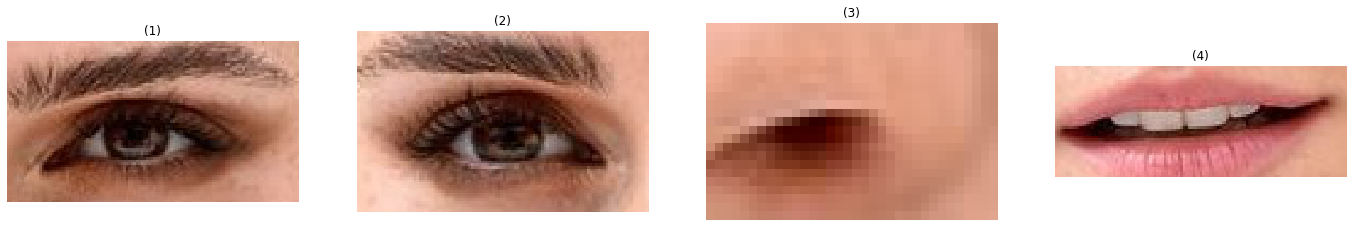

(66, 88, 3)


ValueError: could not broadcast input array from shape (65,118,3) into shape (65,15,3)

In [85]:
face = []
L1 = []
L2 = []
boxs1 =[]
boxs2 = []
new_img = []
fff=io.imread("WIN_20191217_16_13_29_Pro.jpg")
face = get_position(fff) 
show_images([face])
rec2 = io.imread('palm/www.jpg')
L2 , boxs2 = landmarks_detection(rec2,0)
#if( face != np.array([]) ):
#L1 , boxs1 = landmarks_detection(face,0)
rec1 = io.imread('palm/ema.jpg')
L1 , boxs1 = landmarks_detection(face,0)

new_img= face_swap(rec2, face, L2, L1,boxs2, boxs1)
 
show_images([new_img])

In [82]:
##the implementation of HOG##

import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        self.img = img
        self.img = np.sqrt(img / float(np.max(img)))
        self.img = self.img * 255
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.angle_unit = 360 // self.bin_size
        assert type(self.bin_size) == int, "bin_size should be integer,"
        assert type(self.cell_size) == int, "cell_size should be integer,"
        assert type(self.angle_unit) == int, "bin_size should be divisible by 360"

    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((height // self.cell_size, width // self.cell_size, self.bin_size))
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)

        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle

    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image

    
# img = cv2.imread('Caltech_WebFaces/pic00059.jpg', cv2.IMREAD_GRAYSCALE)
# io.imshow(img)
def hogfeat(img,visualise=False):
    hog = Hog_descriptor(img, cell_size=8, bin_size=8)
    vector, image = hog.extract()
    # plt.imshow(image, cmap=plt.cm.gray)
    # plt.show()
    if(visualise==True):
        return vector,image
    return vector

In [43]:
# s1 = int(pos[0][0])
# e1 = int(pos[0][1])
# s2 = int(pos[0][2])
# e2 = int(pos[0][3])
# face_detect = ff[s1 : e1 , s2:e2]

In [44]:
# show_images([face_detect])

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov  2 17:46:03 2019

@author: 
"""                      
import time
import os
import numpy as np
import cv2
from skimage.io import imsave,imread,imshow 
from skimage.measure import find_contours
from skimage.morphology import binary_erosion, binary_dilation, binary_closing
import matplotlib.pyplot as plt

'''
a=[]
temp=imread('fist/fist83.png')
orb=cv2.ORB_create()
kp,desc=orb.detectAndCompute(temp,None)
for i in range(83,159,2):
    can=imread('fist/fist'+str(i)+'.png')
    
    
    kp2,desc2=orb.detectAndCompute(can,None)
    a.append (np.sum(desc-desc2)/32)
#newimg=cv2.drawKeypoints(can,kp,None)
#cv2.imshow("newimg",newimg)
print (a)
'''
def get_fname_images_tuple(directory):
    fnames = os.listdir(directory)
    to_return = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = (imread(path))
        to_return.append((fn, gray_scale_image))
        
    return to_return
def area(xmax,xmin,ymax,ymin):
    return (xmax-xmin)*(ymax-ymin)
    
def aspectratio(xmax,xmin,ymax,ymin):
    return (xmax-xmin)/(ymax-ymin)

def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

'''    
def MakeEffect(img,gesture):
    i +=1
    effect=""
    if(gesture=="Wide"):
        
    elif(gesture=="Knife_Horizontal"):
        
    elif(gesture=="Normal palm"):
        
    elif(gesture=="closed palm"):
        
    elif(gesture=="Victory"):
        
    elif(gesture=="Three"):
        
    elif(gesture=="Knife Vertical):
        
    imsave(effect+"/"+str(i)+".png",img)
'''        


#"KnifeVV/knifev81.png"
#'KnifeHH/knifev31.png'
#'closed palm/knifev65.png'
#'nasr/nasr39.png'
#arr=imread('fist2/fist89.png')
def contours(arr):
    window = np.array([
    [ 1, 1, 1],
    [ 1, 1, 1],
    [ 1, 1, 1]
])
    
    arr= binary_dilation(arr,window)
    contours=find_contours(arr, 0.8)
    bounding_boxes = []
    minx,maxx,miny,maxy=[],[],[],[]
    for cnt in contours:
        Ymin= np.min(cnt[:,0])
        Ymax= np.max(cnt[:,0])
        Xmin= np.min(cnt[:,1])
        Xmax= np.max(cnt[:,1])
        #if(0.05<=(Xmax-Xmin)/(Ymax-Ymin)<=50):
        if area (int(Xmax),int(Xmin),int(Ymax),int(Ymin)) <38000:
            bounding_boxes.append([int(Xmin), int(Xmax), int(Ymin), int(Ymax)])
    for i in range (0,len(bounding_boxes)):
    #if bounding_boxes[i][1]-bounding_boxes[i][0]<150 and bounding_boxes[i][3]-bounding_boxes[i][2]<150:
        minx.append(bounding_boxes[i][0])
        maxx.append(bounding_boxes[i][1])
        miny.append(bounding_boxes[i][2])
        maxy.append(bounding_boxes[i][3])
    if len(minx)==0 or len(maxx)==0 or len(miny)==0 or len(maxy)==0:
        return (0,0,0,0)
    miniX=np.min(minx) 
    maxiX=np.max(maxx) 
    miniY=np.min(miny) 
    maxiY=np.max(maxy) 
    return(maxiX,miniX,maxiY,miniY)
def NumPTS(arr,Y,p):
    c,prev=0,0
    row=int(Y+p * (200-Y))
    ##########print (row)
    for i in range (0,200):
        if(arr[row,i]==255):
            if i-prev>5:
            #if 1 :
                c +=1
            prev=i
    return c 
flag=0
rec1=[]
rec2=[]
l1=[]
l2=[]
boxs1=[]
boxs2=[]
def classify(img):
    
    box=contours(img)
    if box==(0,0,0,0):
        return
    #print (box)
    CntArea=area(box[0],box[1],box[2],box[3])
    Ratio=aspectratio(box[0],box[1],box[2],box[3])
    ############print (Ratio,CntArea)
    msg=""
    n=0
    if Ratio>0.9:
        if Ratio <1.2:
            #if CntArea>25000:
            if CntArea<13000:
                #cv2.putText(frame, "Fist", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
                msg="Fist"
                n=0
               
            else:
                #cv2.putText(frame, "Wide", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
                msg="Wide"
                n=0
                
                
        elif Ratio<4.5:
            #cv2.putText(frame, "Knife_Horizontal", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
            #msg="Knife_Horizontal"
            #n=2 if len(fn_img_list)>2 else 0
            msg="Photo Captured"
            #time.sleep(2)
        
            for i in range(15000000):
                n +=1
                n -=1
                #cv2.putText(frame, "Ready", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
            
                #cv2.putText(frame, "", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
                #for i in range(15):
                #    cv2.putText(frame, "Photo Captured", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
                #Call swapping function NewImg= fnName(frame)
                #imshow(NewImg)
                #time.sleep(2)
            
    elif  Ratio>0.55:
        #if CntArea>15000:
        num=NumPTS(img,box[3],0.25)
        ##########print(num)
        if num in [4,5,6,7,8,9]:
            #cv2.putText(frame, "Normal palm", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
            msg="Normal palm"
            n=6
        elif CntArea<12000:  
            #cv2.putText(frame, "Fist", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
            msg="Fist"
            n=0 if len(fn_img_list)>6 else 0
            #cv2.imshow("frame",frame)
            #imshow(frame)
            #imsave("CurrentImg.png",frame)
            #CurrentImg=frame
    elif Ratio>0.4:
        N=NumPTS(img,box[3],0.25)
        #print (N)
        if N in [1,2]:
            #cv2.putText(frame, "Closed palm", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
            msg="closed palm"
            n=1 if len(fn_img_list)>1 else 0
        elif N in[3,4]:
            #cv2.putText(frame, "Victory", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
            msg="Victory"
            n=3 if len(fn_img_list)>3 else 0
        elif N in [5,6]:
            #cv2.putText(frame, "Three", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
            msg="Three"
            n=4 if len(fn_img_list)>4 else 0
    elif Ratio>0.2 and Ratio <0.32:
        #cv2.putText(frame, "Knife Vertical", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
        msg="Knife Vertical"
        n=5 if len(fn_img_list)>5 else 0
    cv2.putText(frame, msg, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2)
    new_img=[]
    rec2=imread('palm/www.jpg')
    #if msg == "Photo Captured":
     #   rec1=get_position(frame)
    #else:
        #rec1=get_position(frame)
       
        #if( rec1 != []):
    if msg=="Photo Captured":
        L1 , boxs1 = landmarks_detection(fn_img_list[0][1],0)
        L2 , boxs2 = landmarks_detection(rec2,0)
        #if( rec1 != [] and rec2 != []):
        new_img= face_swap(fn_img_list[0][1], rec2, L1, L2,boxs1, boxs2)
        rec1=[]
        rec2=[]

            
            
        
        #NewImage=Call Swapping function(fn_img_list[n][1])
        #OutArr.append(fn_img_list[n][1])
    #else:
        #NewImage=Call Swapping function(frame)
    if len(new_img)!=0:
        OutArr.append(NewImage)
        
    #Call swapping function here
    #j +=1
    #if j >=len(fn_img_list):
    #    j=0    
    return msg

#'Wide/wide91.png'
#'KnifeVV/knifev115.png'
#KnifeVV
#'palm/file53.png'
#'closed palm/clpalm33.png'
#'nasr/nasr41.png'
#'closed palm/clpalm46.png'
#T=imread('KnifeHH/knifev53.png')
#imshow(T)
#classification=classify (T)
#print (classification)#binary_closing(can,W)
#imsave("fist"+str(i)+".png",can)

fn_img_list = get_fname_images_tuple(r'palm')
OutArr=[] 
j=0   
cap = cv2.VideoCapture(0)
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == False:
        break
    # Capture frames from the camera
    ret, frame = cap.read()
      
    frame=cv2.flip(frame,1)
    CurrentImg=frame
    kernel = np.ones((5,5),np.uint8)
    
    #define region of interest
    roi=frame[100:300, 100:300]
    cv2.rectangle(frame,(100,100),(300,300),(0,255,0),0)
    roi = cv2.GaussianBlur(roi,(3,3),3)
    temp = cv2.GaussianBlur(roi,(5,5),3)
    temp=cv2.bilateralFilter(temp,7,49,3)
    temp=cv2.medianBlur(temp,3)
    can= cv2.Canny(temp,50,100,0.33)
    classify(can)

    

    
  
    cv2.imshow('frame',frame)
    cv2.imshow('can',can)
   
    #exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        show_images(OutArr)
        break
    
    # When everything done, release the video capture object
    
    
    # Display the resulting frame
    #cv2.imshow('Frame',frame)
    
    # Press Q on keyboard to  
cap.release()

# Closes all the frames
cv2.destroyAllWindows()

#img=cv2.imread('palm/file42.png')
#cv2.imshow('img',img)

 